In [1]:
import os
import sys
import pickle
import json
from typing import List
from pycocotools import mask as mask_utils
# from einops import rearrange, reduce
import torch
import numpy as np
import torch
import torch.nn.functional as F
import pickle
import itertools
import math
import argparse
from tqdm import tqdm
import torch.nn.functional as F
from torch import nn, optim
import torch
import torch.nn as nn
from torch.optim import Adam
from sklearn.metrics import roc_auc_score, average_precision_score
from tqdm import tqdm
import os
import numpy as np
from path import Path
import os
import pickle
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import os
import pickle
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import os
import pickle
from tqdm import tqdm
# import logging, coloredlogs

/home/st34/miniconda3/envs/dino/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%cd ~/st34

/home/st34/st34


In [3]:
def save_file(filename, data, json_numpy=False):
    parent_dir = os.path.dirname(filename)
    if not os.path.exists(parent_dir):
        os.makedirs(parent_dir)
    Path(parent_dir).chmod(0o0777)
    file_ext = os.path.splitext(filename)[1]       
    if file_ext == ".npy":
        with open(filename, "wb+") as fopen:
            np.save(fopen, data)
    elif file_ext == ".json":
        if not json_numpy:
            with open(filename, 'w+') as fopen:
                json.dump(data, fopen, indent=2)
        else:
            with open(filename, "w+") as fopen:
                json.dump(data, fopen, cls=NumpyArrayEncoder)
    elif file_ext == ".yaml":
        with open(filename, "w+") as fopen:
            dump = yaml.dump(data)
            fopen.write(dump)
            fopen.flush()
    else:
        # assume file is pickle
        with open(filename, "wb+") as fopen:
            pickle.dump(data, fopen)
    Path(filename).chmod(0o0777)

def open_file(filename):
    """
    Based on https://github.com/salesforce/LAVIS/blob/main/lavis/common/utils.py
    Supported:
        .pkl, .pickle, .npy, .json
    """
    file_ext = os.path.splitext(filename)[1]
    if file_ext == '.txt':
        with open(filename,'r+') as fopen:
            data = fopen.readlines()
    elif file_ext in [".npy",".npz"]:
        data = np.load(filename,allow_pickle=True)
    elif file_ext == '.json':
        with open(filename,'r+') as fopen:
            data = json.load(fopen)
    elif file_ext == ".yaml":
        with open(filename,'r+') as fopen:
            data = yaml.load(fopen,Loader=yaml.FullLoader)
    else:
        # assume pickle 
        with open(filename,"rb+") as fopen:
            data = pickle.load(fopen)
    return data 

In [4]:
dino_feature_dir = "/shared/rsaas/dino_sam/features/dinov2/ADE20K/train"
train_region_labels_dir = "/shared/rsaas/dino_sam/region_labels/ADE20K/train"
sam_region_embedding_dir="/shared/rsaas/dino_sam/sam_region_embeddings/ADE20K/train"
max_pool_dir="/shared/rsaas/dino_sam/region_features_max_pooled/train"

label_all = []

##First lets get the labels area wise
label_files = os.listdir(train_region_labels_dir)

for file_name in tqdm(label_files):
    if '.pkl'  not in file_name:
        file_name = file_name + '.pkl'
    sam_masks = open_file(os.path.join(max_pool_dir,file_name))
    file_labels = open_file(os.path.join(train_region_labels_dir,file_name))

    for i, area in enumerate(sam_masks):
        area_label = file_labels[i]['labels']
        target_label = list(area_label.keys())[0]

        if area_label[target_label] == 1:
            label_all.append(target_label)

100%|██████████| 20210/20210 [02:02<00:00, 164.50it/s]


In [4]:
class CustomDataset(Dataset):
    def __init__(self, sam_embed_dir, dino_feat_dir, train_region_labels_dir, max_pool_dir, sam_folder):
        super().__init__()
        self.sam_embed_files = [f for f in os.listdir(sam_embed_dir) if f.endswith('.pkl')]
        self.dino_feat_files = [f for f in os.listdir(dino_feat_dir) if f.endswith('.pkl')]
        self.label_files = [f for f in os.listdir(train_region_labels_dir) if f.endswith('.pkl')]
        self.sam_embed_dir = sam_embed_dir
        self.dino_feat_dir = dino_feat_dir
        self.train_region_labels_dir = train_region_labels_dir
        self.max_pool_dir = max_pool_dir
        self.sam_folder=sam_folder

    def __len__(self):
        return len(self.sam_embed_files)

    def __getitem__(self, idx):
        sam_embed_file = self.sam_embed_files[idx]
        dino_feat_file = self.dino_feat_files[idx]
        label_file = self.label_files[idx]

        # Load SAM region embeddings
        with open(os.path.join(self.sam_embed_dir, sam_embed_file), 'rb') as f:
            sam_embeds_all = pickle.load(f)

        # Load DINO whole image features
        with open(os.path.join(self.dino_feat_dir, dino_feat_file), 'rb') as f:
            dino_feats = pickle.load(f)

        # Load labels
        max_pool_masks = open_file(os.path.join(self.max_pool_dir, label_file))
        file_labels = open_file(os.path.join(self.train_region_labels_dir, label_file))

        # Filtering the SAM embeddings based on the presence of labels
        sam_embeds = []
        label_all = []
        for i, area in enumerate(max_pool_masks):
            area_label = file_labels[i]['labels']
            target_label = list(area_label.keys())[0]
            if area_label[target_label] == 1:
                label_all.append(target_label)
                sam_embeds.append(sam_embeds_all[i])

        # print(f"Index {idx} corresponds to files: {sam_embed_file}, {dino_feat_file}, {label_file}")
        # print(f"Data point {idx}: {len(sam_embeds)} SAM embeddings, {len(label_all)} labels")

        return torch.tensor(sam_embeds), torch.tensor(dino_feats), torch.tensor(label_all, dtype=torch.long)

# Usage:
# sam_embed_dir = "/shared/rsaas/dino_sam/sam_region_embeddings/ADE20K/train"
sam_embed_dir="/shared/rsaas/dino_sam/sam_region_embeddings/pascal_voc/train_upscale"
dino_feat_dir = "/shared/rsaas/dino_sam/features/dinov2/pascal_voc_layer_23/train"
train_region_labels_dir = '/shared/rsaas/dino_sam/region_labels/pascal_voc/train'
max_pool_dir = "/shared/rsaas/dino_sam/region_features/dinov2/pascal_voc_layer_23/train"
sam_folder = "/shared/rsaas/dino_sam/sam_output/pascal_voc/train"
dataset= CustomDataset(sam_embed_dir, dino_feat_dir, train_region_labels_dir, max_pool_dir, sam_folder)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [68]:
dataset = CustomDataset(sam_embed_dir, dino_feat_dir, train_region_labels_dir, max_pool_dir, sam_folder)

# Manually call __getitem__ on a few indices
for idx in range(3):  
    dataset.__getitem__(idx)

Index 0 corresponds to files: 2010_005820.pkl, 2010_005820.pkl, 2010_005820.pkl
Data point 0: 50 SAM embeddings, 50 labels
Index 1 corresponds to files: 2010_005317.pkl, 2010_005317.pkl, 2010_005317.pkl
Data point 1: 14 SAM embeddings, 14 labels
Index 2 corresponds to files: 2009_000895.pkl, 2009_000895.pkl, 2009_000895.pkl
Data point 2: 128 SAM embeddings, 128 labels


In [7]:
sample = dataset[0]

Index 0 corresponds to files: ADE_train_00019668.pkl, ADE_train_00019668.pkl, ADE_train_00019668.pkl
Data point 0: 95 SAM embeddings, 95 labels


In [71]:
# for i, (sam_embeds, dino_feats, labels) in enumerate(dataloader):
#     print(f"Batch {i}:")
#     print(f"SAM embeddings shape: {sam_embeds.shape}")
#     print(f"DINO features shape: {dino_feats.shape}")
#     print(f"Labels shape: {labels.shape}")

#     # 3. Inspect values
#     print(f"Unique values in SAM embeddings: {torch.unique(sam_embeds)}")
#     print(f"Unique values in DINO features: {torch.unique(dino_feats)}")
    
#     if torch.isnan(sam_embeds).any():
#         print("Warning: NaN values detected in SAM embeddings!")
#     if torch.isnan(dino_feats).any():
#         print("Warning: NaN values detected in DINO features!")
#     if torch.isnan(labels.float()).any():
#         print("Warning: NaN values detected in labels!")

# # 5. Check data distribution
# all_labels = []
# for _, _, labels in dataloader:
#     all_labels.extend(labels.tolist())

# from collections import Counter
# label_counts = Counter(all_labels)
# print("Label distribution:", label_counts)

In [ ]:
dino_feature_dir = "/shared/rsaas/dino_sam/features/dinov2/ADE20K/train"
train_region_labels_dir = "/shared/rsaas/dino_sam/region_labels/ADE20K/train"
sam_region_embedding_dir="/shared/rsaas/dino_sam/sam_region_embeddings/ADE20K/train"
max_pool_dir="/shared/rsaas/dino_sam/region_features_max_pooled/train"

label_all = []

##First lets get the labels area wise
label_files = os.listdir(train_region_labels_dir)

for file_name in tqdm(label_files):
    if '.pkl'  not in file_name:
        file_name = file_name + '.pkl'
    sam_masks = open_file(os.path.join(max_pool_dir,file_name))
    file_labels = open_file(os.path.join(train_region_labels_dir,file_name))

    for i, area in enumerate(sam_masks):
        area_label = file_labels[i]['labels']
        target_label = list(area_label.keys())[0]

        if area_label[target_label] == 1:
            label_all.append(target_label)

In [16]:
sam_folder = "/shared/rsaas/dino_sam/sam_output/ADE20K/train"  # Change this to your folder path
sam_files = os.listdir(sam_folder)
len(sam_files)

20210

In [35]:
with open('/shared/rsaas/dino_sam/sam_output/ADE20K/train/ADE_train_00006321.json','r+') as s:
    sam_regions = json.load(s)
'Number of SAM regions = '+ str(len(sam_regions))

'Number of SAM regions = 41'

In [28]:
import json
import os

dir_path = '/shared/rsaas/dino_sam/sam_output/ADE20K/train/'
all_files = [f for f in os.listdir(dir_path) if f.endswith('.json')]

all_files.sort()
for file in all_files[:10]:
    file_path = os.path.join(dir_path, file)
    with open(file_path, 'r') as f:
        sam_regions = json.load(f)
    print(f'File: {file}, Number of SAM regions = {len(sam_regions)}')

File: ADE_train_00000001.json, Number of SAM regions = 172
File: ADE_train_00000002.json, Number of SAM regions = 114
File: ADE_train_00000003.json, Number of SAM regions = 80
File: ADE_train_00000004.json, Number of SAM regions = 46
File: ADE_train_00000005.json, Number of SAM regions = 97
File: ADE_train_00000006.json, Number of SAM regions = 60
File: ADE_train_00000007.json, Number of SAM regions = 85
File: ADE_train_00000008.json, Number of SAM regions = 33
File: ADE_train_00000009.json, Number of SAM regions = 39
File: ADE_train_00000010.json, Number of SAM regions = 60


In [29]:
import os
import pickle

dir_path = '/shared/rsaas/dino_sam/region_features_max_pooled/train'

all_files = [f for f in os.listdir(dir_path) if f.endswith('.pkl')]

all_files.sort()

for file in all_files[:10]:
    file_path = os.path.join(dir_path, file)
    with open(file_path, 'rb') as f:
        region_features = pickle.load(f)
    print(f'File: {file}, Number of regions = {len(region_features)}')

File: ADE_train_00000001.pkl, Number of regions = 172
File: ADE_train_00000002.pkl, Number of regions = 114
File: ADE_train_00000003.pkl, Number of regions = 80
File: ADE_train_00000004.pkl, Number of regions = 46
File: ADE_train_00000005.pkl, Number of regions = 97
File: ADE_train_00000006.pkl, Number of regions = 60
File: ADE_train_00000007.pkl, Number of regions = 85
File: ADE_train_00000008.pkl, Number of regions = 33
File: ADE_train_00000009.pkl, Number of regions = 39
File: ADE_train_00000010.pkl, Number of regions = 60


In [30]:
import os
import pickle

dir_path = '/shared/rsaas/dino_sam/region_labels/ADE20K/train'

all_files = [f for f in os.listdir(dir_path) if f.endswith('.pkl')]

all_files.sort()

for file in all_files[:10]:
    file_path = os.path.join(dir_path, file)
    with open(file_path, 'rb') as f:
        labels = pickle.load(f)
    print(f'File: {file}, Number of regions = {len(labels)}')

File: ADE_train_00000001.pkl, Number of regions = 172
File: ADE_train_00000002.pkl, Number of regions = 114
File: ADE_train_00000003.pkl, Number of regions = 80
File: ADE_train_00000004.pkl, Number of regions = 46
File: ADE_train_00000005.pkl, Number of regions = 97
File: ADE_train_00000006.pkl, Number of regions = 60
File: ADE_train_00000007.pkl, Number of regions = 85
File: ADE_train_00000008.pkl, Number of regions = 33
File: ADE_train_00000009.pkl, Number of regions = 39
File: ADE_train_00000010.pkl, Number of regions = 60


In [31]:
import os
import pickle

dir_path = '/shared/rsaas/dino_sam/sam_region_embeddings/ADE20K/train'

all_files = [f for f in os.listdir(dir_path) if f.endswith('.pkl')]

all_files.sort()

for file in all_files[:10]:
    file_path = os.path.join(dir_path, file)
    with open(file_path, 'rb') as f:
        region_features = pickle.load(f)
    print(f'File: {file}, Number of regions = {len(region_features)}')

File: ADE_train_00000001.pkl, Number of regions = 172
File: ADE_train_00000002.pkl, Number of regions = 114
File: ADE_train_00000003.pkl, Number of regions = 80
File: ADE_train_00000004.pkl, Number of regions = 46
File: ADE_train_00000005.pkl, Number of regions = 97
File: ADE_train_00000006.pkl, Number of regions = 60
File: ADE_train_00000007.pkl, Number of regions = 85
File: ADE_train_00000008.pkl, Number of regions = 33
File: ADE_train_00000009.pkl, Number of regions = 39
File: ADE_train_00000010.pkl, Number of regions = 60


In [5]:
class AttentionSegmentation(nn.Module):
    def __init__(self, embed_dim, num_heads, num_classes):
        super(AttentionSegmentation, self).__init__()

        # Multi-Head Attention
        self.attention = nn.MultiheadAttention(embed_dim, num_heads)
        
        # Final linear layer to output area-wise labels
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, sam_embeds, dino_feats):
        # Compute the average feature representation of DINO embeddings for the entire image
        #dino_avg = dino_feats.mean(dim=[-1, -2]).repeat(sam_embeds.shape[0], 1, 1)

        # sam_embeds are queries: shape [seq_len, batch_size, embed_dim]
        # dino_avg are keys and values: shape [seq_len, batch_size, embed_dim]
        attn_output, _ = self.attention(sam_embeds, dino_feats, dino_feats)

        # Predict area-wise labels
        output = self.fc(attn_output)
        
        return output

In [6]:
class AddDinoV2PosEmbeds(nn.Module):
    def __init__(self, dino_pos_embeds: torch.Tensor):
        super().__init__()
        self.pos_embeds = dino_pos_embeds.detach()

    def forward(self, dino_feats):
        '''
        Dino features are expected to be of shape (bsize, patches_h, patches_w, dim)
        where patches_h = padded_h // patch_size and patches_w = padded_w // patch_size.

        The CLS token should NOT be included.
        '''
        assert dino_feats.dim() == 4, 'Expected input of shape (bsize, patches_h, patches_w, dim))'
        interpolated_pos_embeds = self.interpolate_pos_encoding(dino_feats)

        return dino_feats + interpolated_pos_embeds

    def interpolate_pos_encoding(self, dino_feats: torch.Tensor):
        # Modified from https://github.com/facebookresearch/dinov2/blob/44abdbe27c0a5d4a826eff72b7c8ab0203d02328/dinov2/models/vision_transformer.py#L164
        previous_dtype = dino_feats.dtype
        npatch = dino_feats.shape[1] * dino_feats.shape[2]
        N = self.pos_embeds.shape[1] - 1 # Ignore CLS
        sqrt_N = np.sqrt(N)


        #if npatch == N and dino_feats.shape[1] == dino_feats.shape[2]:
         #   return self.pos_embeds[:, 1:].reshape(self.pos_embeds.shape[0], int(sqrt_N), int(sqrt_N))

        pos_embed = self.pos_embeds.float()
        patch_pos_embed = pos_embed[:, 1:] # Ignore CLS embedding
        dim = dino_feats.shape[-1]

        # Target height, width is height, width of the dino features
        h0 = dino_feats.shape[1]
        w0 = dino_feats.shape[2]

        # we add a small number to avoid floating point error in the interpolation
        # see discussion at https://github.com/facebookresearch/dino/issues/8
        w0, h0 = w0 + 0.1, h0 + 0.1

        sx, sy = float(w0) / sqrt_N, float(h0) / sqrt_N
        patch_pos_embed = nn.functional.interpolate(
            patch_pos_embed.reshape(1, int(sqrt_N), int(sqrt_N), dim).permute(0, 3, 1, 2), # (dim to second spot)
            scale_factor=(sy, sx),
            mode="bicubic",
        )

        assert int(h0) == patch_pos_embed.shape[-2]
        assert int(w0) == patch_pos_embed.shape[-1]
        patch_pos_embed = patch_pos_embed.permute(0, 2, 3, 1) # (dim to end)

        return patch_pos_embed.to(previous_dtype)

In [10]:
from tqdm import tqdm

# Model instantiation
embed_dim = 1024  # Adjusted feature dimension for sam_embeds and dino_feats
num_heads = 8  # Number of heads in MultiheadAttention mechanism
num_classes = 151  # Number of classes for area-wise labels

dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
model = AttentionSegmentation(embed_dim, num_heads, num_classes)
adder = AddDinoV2PosEmbeds(dino.pos_embed)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss()


Using cache found in /home/st34/.cache/torch/hub/facebookresearch_dinov2_main
/home/st34/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/st34/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/st34/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [7]:

# Training loop
for epoch in range(50):  # Example number of epochs
    for sam_embeds, dino_feats, labels in tqdm(dataloader):
        optimizer.zero_grad()

        # Squeeze out extra dimension added by dataloader (1, 1, 1024, h, w) -> (1, 1024, h, w)
        dino_feats = dino_feats.squeeze(1)
        dino_feats = dino_feats.permute(0, 2, 3, 1) # (bsize, 1024, h, w) -> (bsize, h, w, 1024)
        dino_feats = adder(dino_feats) # Add positional embeddings

        # Reshape the DINO features: [batch_size, 1024, height, width] to [height*width, batch_size, 1024]
        # If the spatial dimensions are not consistent, consider using padding or other techniques
        dino_feats = dino_feats.permute(1, 2, 0, 3).reshape(-1, dino_feats.shape[0], embed_dim)

        # Transpose the inputs for the MultiheadAttention
        sam_embeds = sam_embeds.transpose(0, 1) # (embed_dim, n_masks)

        outputs = model(sam_embeds, dino_feats)
        
        # Reshape outputs and labels for loss calculation
        outputs = outputs.transpose(0, 1).view(-1, num_classes)
        labels = labels.view(-1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

Using cache found in /home/st34/.cache/torch/hub/facebookresearch_dinov2_main
/home/st34/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/st34/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/st34/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
  0%|          | 0/1464 [00:00<?, ?it/s]/srv/condor/execute/dir_106648/ipykernel_110462/2727138654.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch

Epoch 1, Loss: 0.15402387082576752


100%|██████████| 1464/1464 [02:00<00:00, 12.15it/s]


Epoch 2, Loss: 0.19234521687030792


100%|██████████| 1464/1464 [01:58<00:00, 12.37it/s]


Epoch 3, Loss: 0.06279391050338745


100%|██████████| 1464/1464 [02:00<00:00, 12.19it/s]


Epoch 4, Loss: 0.06625336408615112


100%|██████████| 1464/1464 [01:49<00:00, 13.37it/s]


Epoch 5, Loss: 0.059938907623291016


100%|██████████| 1464/1464 [01:40<00:00, 14.61it/s]


Epoch 6, Loss: 0.11856924742460251


100%|██████████| 1464/1464 [01:42<00:00, 14.35it/s]


Epoch 7, Loss: 0.021008405834436417


100%|██████████| 1464/1464 [01:53<00:00, 12.87it/s]


Epoch 8, Loss: 0.1580812782049179


100%|██████████| 1464/1464 [02:00<00:00, 12.20it/s]


Epoch 9, Loss: 0.05267233029007912


100%|██████████| 1464/1464 [01:52<00:00, 12.97it/s]


Epoch 10, Loss: 0.0741337239742279


100%|██████████| 1464/1464 [01:43<00:00, 14.20it/s]


Epoch 11, Loss: 0.39886021614074707


100%|██████████| 1464/1464 [01:42<00:00, 14.31it/s]


Epoch 12, Loss: 0.0339006632566452


100%|██████████| 1464/1464 [01:44<00:00, 14.01it/s]


Epoch 13, Loss: 0.11165322363376617


100%|██████████| 1464/1464 [01:46<00:00, 13.77it/s]


Epoch 14, Loss: 0.08766098320484161


100%|██████████| 1464/1464 [01:55<00:00, 12.66it/s]


Epoch 15, Loss: 0.09161882847547531


100%|██████████| 1464/1464 [01:48<00:00, 13.45it/s]


Epoch 16, Loss: 0.06078340485692024


100%|██████████| 1464/1464 [01:51<00:00, 13.18it/s]


Epoch 17, Loss: 0.018661096692085266


100%|██████████| 1464/1464 [01:52<00:00, 13.06it/s]


Epoch 18, Loss: 0.11764728277921677


100%|██████████| 1464/1464 [01:49<00:00, 13.42it/s]


Epoch 19, Loss: 0.006495494861155748


100%|██████████| 1464/1464 [01:48<00:00, 13.48it/s]


Epoch 20, Loss: 0.017473818734288216


100%|██████████| 1464/1464 [01:46<00:00, 13.69it/s]


Epoch 21, Loss: 1.2946491241455078


100%|██████████| 1464/1464 [01:47<00:00, 13.61it/s]


Epoch 22, Loss: 0.3193650245666504


100%|██████████| 1464/1464 [01:45<00:00, 13.82it/s]


Epoch 23, Loss: 0.03220879286527634


100%|██████████| 1464/1464 [01:43<00:00, 14.10it/s]


Epoch 24, Loss: 0.028765186667442322


100%|██████████| 1464/1464 [01:46<00:00, 13.76it/s]


Epoch 25, Loss: 0.0044217584654688835


100%|██████████| 1464/1464 [01:44<00:00, 14.01it/s]


Epoch 26, Loss: 0.016778305172920227


100%|██████████| 1464/1464 [01:47<00:00, 13.65it/s]


Epoch 27, Loss: 0.05384180694818497


100%|██████████| 1464/1464 [01:47<00:00, 13.66it/s]


Epoch 28, Loss: 0.0137576162815094


100%|██████████| 1464/1464 [01:51<00:00, 13.18it/s]


Epoch 29, Loss: 0.01686779409646988


100%|██████████| 1464/1464 [01:44<00:00, 14.00it/s]


Epoch 30, Loss: 0.006825544405728579


100%|██████████| 1464/1464 [01:45<00:00, 13.94it/s]


Epoch 31, Loss: 0.11318354308605194


100%|██████████| 1464/1464 [01:47<00:00, 13.67it/s]


Epoch 32, Loss: 0.0001775269629433751


100%|██████████| 1464/1464 [01:43<00:00, 14.10it/s]


Epoch 33, Loss: 0.00593061838299036


100%|██████████| 1464/1464 [01:45<00:00, 13.85it/s]


Epoch 34, Loss: 0.05688757449388504


100%|██████████| 1464/1464 [01:46<00:00, 13.80it/s]


Epoch 35, Loss: 0.33384108543395996


100%|██████████| 1464/1464 [01:53<00:00, 12.91it/s]


Epoch 36, Loss: 0.5960195660591125


100%|██████████| 1464/1464 [01:48<00:00, 13.48it/s]


Epoch 37, Loss: 0.015575484372675419


100%|██████████| 1464/1464 [01:56<00:00, 12.54it/s]


Epoch 38, Loss: 0.14141249656677246


100%|██████████| 1464/1464 [01:47<00:00, 13.63it/s]


Epoch 39, Loss: 0.24669000506401062


100%|██████████| 1464/1464 [01:44<00:00, 14.00it/s]


Epoch 40, Loss: 0.008319132961332798


100%|██████████| 1464/1464 [01:46<00:00, 13.77it/s]


Epoch 41, Loss: 0.09442794322967529


100%|██████████| 1464/1464 [01:47<00:00, 13.65it/s]


Epoch 42, Loss: 0.03771538287401199


100%|██████████| 1464/1464 [02:20<00:00, 10.44it/s]


Epoch 43, Loss: 0.05162985622882843


100%|██████████| 1464/1464 [02:51<00:00,  8.53it/s]


Epoch 44, Loss: 0.06726466864347458


100%|██████████| 1464/1464 [02:28<00:00,  9.83it/s]


Epoch 45, Loss: 0.04972761124372482


100%|██████████| 1464/1464 [02:30<00:00,  9.73it/s]


Epoch 46, Loss: 0.0015709670260548592


100%|██████████| 1464/1464 [01:45<00:00, 13.93it/s]


Epoch 47, Loss: 0.19143901765346527


100%|██████████| 1464/1464 [01:44<00:00, 14.07it/s]


Epoch 48, Loss: 0.02993091754615307


100%|██████████| 1464/1464 [01:41<00:00, 14.37it/s]


Epoch 49, Loss: 0.20461636781692505


100%|██████████| 1464/1464 [01:44<00:00, 13.96it/s]

Epoch 50, Loss: 0.00010049552656710148


In [18]:
batch = next(iter(dataloader))

Index 0 corresponds to files: ADE_train_00019668.pkl, ADE_train_00019668.pkl, ADE_train_00019668.pkl
Data point 0: 95 SAM embeddings, 95 labels


In [38]:
outputs.shape

torch.Size([95, 21])

In [10]:
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for sam_embeds, dino_feats, labels in tqdm(dataloader):

        # [Similar preprocessing as training loop...]
        dino_feats = dino_feats.squeeze(1)
        dino_feats = dino_feats.permute(0, 2, 3, 1)
        dino_feats = adder(dino_feats)
        dino_feats = dino_feats.permute(1, 2, 0, 3).reshape(-1, dino_feats.shape[0], embed_dim)
        sam_embeds = sam_embeds.transpose(0, 1)

        outputs = model(sam_embeds, dino_feats)
        outputs = outputs.transpose(0, 1).view(-1, num_classes)  # Reshaping outputs for comparison
        _, predicted = torch.max(outputs.data, 1)  # Get the index (class) with the highest score

        labels = labels.view(-1)  # Ensure that the labels tensor is also reshaped correctly

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on the validation/test data: {accuracy}%')

100%|██████████| 1464/1464 [01:06<00:00, 22.04it/s]

Accuracy on the validation/test data: 95.53116282450864%


In [11]:
sam_embed_val_dir = "/shared/rsaas/dino_sam/sam_region_embeddings/pascal_voc/val_upscale"
dino_feat_val_dir = "/shared/rsaas/dino_sam/features/dinov2/pascal_voc_layer_23/val"
train_region_labels_val_dir = '/shared/rsaas/dino_sam/region_labels/pascal_voc/val'
max_pool_val_dir = "/shared/rsaas/dino_sam/region_features/dinov2/pascal_voc_layer_23/val"
sam_val_folder = "/shared/rsaas/dino_sam/sam_output/pascal_voc/val"

# Create validation dataset and dataloader
val_dataset = CustomDataset(sam_embed_val_dir, dino_feat_val_dir, train_region_labels_val_dir, max_pool_val_dir, sam_val_folder)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [12]:
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for sam_embeds, dino_feats, labels in tqdm(val_dataloader):

        # [Similar preprocessing as training loop...]
        dino_feats = dino_feats.squeeze(1)
        dino_feats = dino_feats.permute(0, 2, 3, 1)
        dino_feats = adder(dino_feats)
        dino_feats = dino_feats.permute(1, 2, 0, 3).reshape(-1, dino_feats.shape[0], embed_dim)
        sam_embeds = sam_embeds.transpose(0, 1)

        outputs = model(sam_embeds, dino_feats)
        outputs = outputs.transpose(0, 1).view(-1, num_classes)  # Reshaping outputs for comparison
        _, predicted = torch.max(outputs.data, 1)  # Get the index (class) with the highest score

        labels = labels.view(-1)  # Ensure that the labels tensor is also reshaped correctly

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on the validation/test data: {accuracy}%')

100%|██████████| 1449/1449 [04:20<00:00,  5.56it/s]

Accuracy on the validation/test data: 85.10184613658043%


In [13]:
accuracy

85.10184613658043

In [20]:
import torch
# from utils import mean_iou
from tqdm import tqdm


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def evaluate_model(model, val_dataloader, num_classes):
    model.eval()  # Set the model to evaluation mode

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for sam_embeds, dino_feats, labels in tqdm(val_dataloader):

            dino_feats = dino_feats.squeeze(1)
            dino_feats = dino_feats.permute(0, 2, 3, 1)
            dino_feats = adder(dino_feats)
            dino_feats = dino_feats.permute(1, 2, 0, 3).reshape(-1, dino_feats.shape[0], embed_dim)
            sam_embeds = sam_embeds.transpose(0, 1)

            outputs = model(sam_embeds, dino_feats)
            outputs = outputs.transpose(0, 1).view(-1, num_classes)
            
            _, predicted = torch.max(outputs.data, 1)
            labels = labels.view(-1)

            all_predictions.append(predicted.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    return all_predictions, all_labels

def compute_mIOU(predictions, labels, num_classes):
    # Compute mIOU using predictions and ground truth annotations.
    num_classes = num_classes -1 
    reduce_labels = True
    n_classes = num_classes - 1 if reduce_labels else num_classes
    miou = mean_iou(predictions, labels, num_labels=n_classes, ignore_index=255, reduce_labels=reduce_labels)
    print(miou)


if __name__ == '__main__':
    model =model
    val_dataloader = val_dataloader
    num_classes = 151
    predictions, labels = evaluate_model(model, val_dataloader, num_classes)
    compute_mIOU(predictions, labels, num_classes)


100%|██████████| 1449/1449 [01:02<00:00, 23.23it/s]


NameError: name 'total_intersect_and_union' is not defined

In [19]:
def mean_iou(
    results,
    gt_seg_maps,
    num_labels,
    ignore_index: bool,
    nan_to_num = None,
    label_map = None,
    reduce_labels: bool = False,
    reduce_pred_labels: bool = False,
):
    """Calculate Mean Intersection and Union (mIoU).
    Args:
        results (`ndarray`):
            List of prediction segmentation maps, each of shape (height, width).
        gt_seg_maps (`ndarray`):
            List of ground truth segmentation maps, each of shape (height, width).
        num_labels (`int`):
            Number of categories.
        ignore_index (`int`):
            Index that will be ignored during evaluation.
        nan_to_num (`int`, *optional*):
            If specified, NaN values will be replaced by the number defined by the user.
        label_map (`dict`, *optional*):
            Mapping old labels to new labels. The parameter will work only when label is str.
        reduce_labels (`bool`, *optional*, defaults to `False`):
            Whether or not to reduce all label values of segmentation maps by 1. Usually used for datasets where 0 is used for background,
            and background itself is not included in all classes of a dataset (e.g. ADE20k). The background label will be replaced by 255.
        reduce_pred_labels (`bool`, *optional*, defaults to `False`):
            Same as `reduce_labels` but for prediction labels.
    Returns:
        `Dict[str, float | ndarray]` comprising various elements:
        - *mean_iou* (`float`):
            Mean Intersection-over-Union (IoU averaged over all categories).
        - *mean_accuracy* (`float`):
            Mean accuracy (averaged over all categories).
        - *overall_accuracy* (`float`):
            Overall accuracy on all images.
        - *per_category_accuracy* (`ndarray` of shape `(num_labels,)`):
            Per category accuracy.
        - *per_category_iou* (`ndarray` of shape `(num_labels,)`):
            Per category IoU.
    """
    total_area_intersect, total_area_union, total_area_pred_label, total_area_label = total_intersect_and_union(
        results, gt_seg_maps, num_labels, ignore_index, label_map, reduce_labels, reduce_pred_labels
    )

    # compute metrics
    metrics = dict()

    all_acc = total_area_intersect.sum() / total_area_label.sum()
    iou = total_area_intersect / total_area_union
    acc = total_area_intersect / total_area_label

    metrics["mean_iou"] = np.nanmean(iou)
    metrics["mean_accuracy"] = np.nanmean(acc)
    metrics["overall_accuracy"] = all_acc
    metrics["per_category_iou"] = iou
    metrics["per_category_accuracy"] = acc

    if nan_to_num is not None:
        metrics = dict(
            {metric: np.nan_to_num(metric_value, nan=nan_to_num) for metric, metric_value in metrics.items()}
        )

    return metrics

In [7]:
!pip install matplotlib

In [8]:
from torch.utils.data import random_split
from tqdm import tqdm

# Assuming dataloader is based on a dataset object
train_size = int(0.8 * len(dataloader.dataset))
val_size = len(dataloader.dataset) - train_size

train_dataset, val_dataset = random_split(dataloader.dataset, [train_size, val_size])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)

# Model instantiation, optimizer and loss definition remain unchanged

def compute_loss(dataloader, model, criterion):
    total_loss = 0.0
    with torch.no_grad():
        for sam_embeds, dino_feats, labels in dataloader:
            # [Same preprocessing as in your training loop...]
            dino_feats = dino_feats.squeeze(1)
            dino_feats = dino_feats.permute(0, 2, 3, 1)
            dino_feats = adder(dino_feats)
            dino_feats = dino_feats.permute(1, 2, 0, 3).reshape(-1, dino_feats.shape[0], embed_dim)
            sam_embeds = sam_embeds.transpose(0, 1)
            
            outputs = model(sam_embeds, dino_feats)
            outputs = outputs.transpose(0, 1).view(-1, num_classes)
            labels = labels.view(-1)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(dataloader)

  0%|          | 0/1171 [00:00<?, ?it/s]/srv/condor/execute/dir_63414/ipykernel_64652/1374343028.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525552843/work/torch/csrc/utils/tensor_new.cpp:230.)
  return torch.tensor(sam_embeds), torch.tensor(dino_feats), torch.tensor(label_all, dtype=torch.long)
100%|██████████| 1171/1171 [01:27<00:00, 13.45it/s]


Epoch 1, Train Loss: 1.2831833353926239, Validation Loss: 1.0407299545717523


100%|██████████| 1171/1171 [01:22<00:00, 14.12it/s]


Epoch 2, Train Loss: 0.8773936035362471, Validation Loss: 0.7004248736483448


100%|██████████| 1171/1171 [01:24<00:00, 13.92it/s]


Epoch 3, Train Loss: 0.6080472200152955, Validation Loss: 1.4639408802832143


100%|██████████| 1171/1171 [01:21<00:00, 14.36it/s]


Epoch 4, Train Loss: 1.4854464241891048, Validation Loss: 1.7331591071211336


100%|██████████| 1171/1171 [01:22<00:00, 14.25it/s]


Epoch 5, Train Loss: 0.4790562907086314, Validation Loss: 0.6011328092527317


100%|██████████| 1171/1171 [01:23<00:00, 13.97it/s]


Epoch 6, Train Loss: 0.37859389851777986, Validation Loss: 0.7067425848258904


100%|██████████| 1171/1171 [01:26<00:00, 13.50it/s]


Epoch 7, Train Loss: 0.4166657027607425, Validation Loss: 0.5947056969245514


100%|██████████| 1171/1171 [01:25<00:00, 13.74it/s]


Epoch 8, Train Loss: 0.4141676265253168, Validation Loss: 0.652670075149838


100%|██████████| 1171/1171 [01:22<00:00, 14.19it/s]


Epoch 9, Train Loss: 0.4117843273515414, Validation Loss: 0.7171135787465117


100%|██████████| 1171/1171 [01:24<00:00, 13.80it/s]


Epoch 10, Train Loss: 0.765777468021128, Validation Loss: 1.4265372666939409


100%|██████████| 1171/1171 [01:23<00:00, 14.08it/s]


Epoch 11, Train Loss: 0.5210354201297703, Validation Loss: 0.5596246167646758


100%|██████████| 1171/1171 [01:23<00:00, 13.98it/s]


Epoch 12, Train Loss: 0.2777508228281586, Validation Loss: 0.5096075014809232


100%|██████████| 1171/1171 [01:23<00:00, 13.94it/s]


Epoch 13, Train Loss: 0.5326363548576367, Validation Loss: 1.7457490949282546


100%|██████████| 1171/1171 [01:22<00:00, 14.22it/s]


Epoch 14, Train Loss: 0.5282976094732965, Validation Loss: 0.6439835414645432


100%|██████████| 1171/1171 [01:22<00:00, 14.24it/s]


Epoch 15, Train Loss: 0.27647729603265664, Validation Loss: 0.5132978385860444


100%|██████████| 1171/1171 [01:22<00:00, 14.14it/s]


Epoch 16, Train Loss: 0.26225661572126374, Validation Loss: 0.6507793078564976


100%|██████████| 1171/1171 [01:22<00:00, 14.16it/s]


Epoch 17, Train Loss: 0.472963497484884, Validation Loss: 0.8767770079885215


100%|██████████| 1171/1171 [01:23<00:00, 13.99it/s]


Epoch 18, Train Loss: 0.3266886129606729, Validation Loss: 1.2533646472749307


100%|██████████| 1171/1171 [01:23<00:00, 14.05it/s]


Epoch 19, Train Loss: 0.3211179207030974, Validation Loss: 0.6694977659418939


100%|██████████| 1171/1171 [01:23<00:00, 14.10it/s]


Epoch 20, Train Loss: 0.41785948201931805, Validation Loss: 0.8506036790175366


100%|██████████| 1171/1171 [01:22<00:00, 14.17it/s]


Epoch 21, Train Loss: 0.2935572623464237, Validation Loss: 0.6756852856203717


100%|██████████| 1171/1171 [01:23<00:00, 13.96it/s]


Epoch 22, Train Loss: 0.27158775923783895, Validation Loss: 0.622227082553481


100%|██████████| 1171/1171 [01:23<00:00, 14.08it/s]


Epoch 23, Train Loss: 0.2216666154268547, Validation Loss: 0.7460593238689808


100%|██████████| 1171/1171 [01:23<00:00, 14.09it/s]


Epoch 24, Train Loss: 0.2230270322771648, Validation Loss: 0.6378767666004679


100%|██████████| 1171/1171 [01:22<00:00, 14.12it/s]


Epoch 25, Train Loss: 0.7990413406560416, Validation Loss: 1.2388813118986368


100%|██████████| 1171/1171 [01:25<00:00, 13.64it/s]


Epoch 26, Train Loss: 0.3337184550703061, Validation Loss: 0.9906302916974723


100%|██████████| 1171/1171 [01:23<00:00, 13.97it/s]


Epoch 27, Train Loss: 0.18581540475513172, Validation Loss: 0.8300880462891642


100%|██████████| 1171/1171 [01:22<00:00, 14.21it/s]


Epoch 28, Train Loss: 0.1680778458224968, Validation Loss: 0.9398043743513639


100%|██████████| 1171/1171 [01:22<00:00, 14.17it/s]


Epoch 29, Train Loss: 0.7558089475451464, Validation Loss: 1.6701476808817726


100%|██████████| 1171/1171 [01:23<00:00, 14.02it/s]


Epoch 30, Train Loss: 0.3680098992197399, Validation Loss: 1.1932882073651654


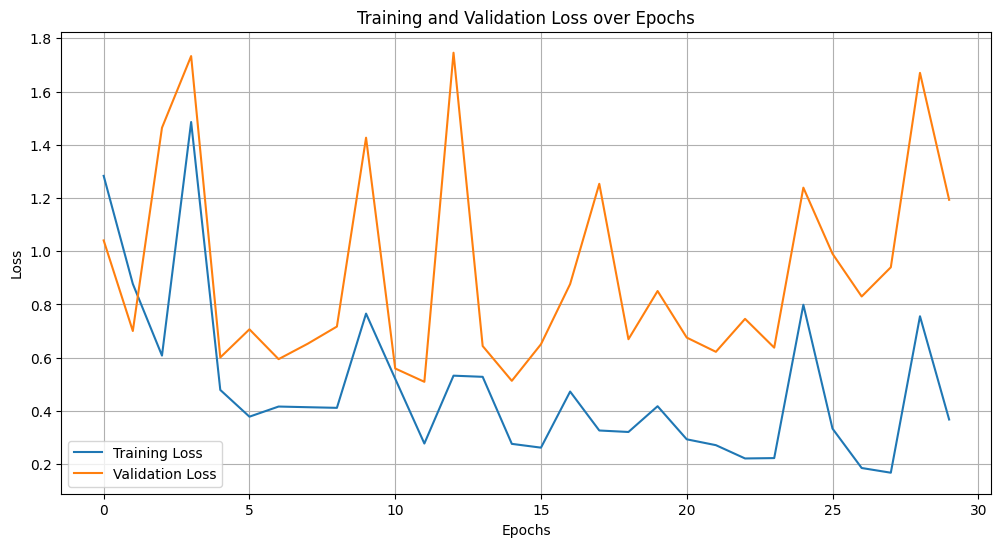

In [11]:
import matplotlib.pyplot as plt

train_losses = []  # List to store training loss for each epoch
val_losses = []    # List to store validation loss for each epoch

# Training loop
for epoch in range(30):  # Example number of epochs
    model.train()
    epoch_train_loss = 0
    for sam_embeds, dino_feats, labels in tqdm(train_dataloader):
        optimizer.zero_grad()

        # [Same preprocessing as in your training loop...]
        dino_feats = dino_feats.squeeze(1)
        dino_feats = dino_feats.permute(0, 2, 3, 1)
        dino_feats = adder(dino_feats)
        dino_feats = dino_feats.permute(1, 2, 0, 3).reshape(-1, dino_feats.shape[0], embed_dim)
        sam_embeds = sam_embeds.transpose(0, 1)

        outputs = model(sam_embeds, dino_feats)
        outputs = outputs.transpose(0, 1).view(-1, num_classes)
        labels = labels.view(-1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_dataloader)  # Average training loss for the epoch
    train_losses.append(epoch_train_loss)

    # Compute validation loss
    model.eval()
    val_loss = compute_loss(val_dataloader, model, criterion)
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1}, Train Loss: {epoch_train_loss}, Validation Loss: {val_loss}")

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()